In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import re
import seaborn as sns
from bs4 import BeautifulSoup
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [2]:
# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\" +
         "OpenClassrooms\\github\\" +
         "OpenClassrooms_Ingenieur_Machine_Learning\\" +
         "Catégorisez automatiquement des questions")

# Lecture des fichiers CSV issus du site "Query Stack Overflow"
fichiers_csv = []
for i in range(9):
    df = pd.read_csv('QueryResults_'+ str(i) + '.csv', sep=',',
                     index_col=None, header=0)
    fichiers_csv.append(df)

df = pd.concat(fichiers_csv, axis=0, ignore_index=True)

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(df.shape)
print(df.columns)
df.head()

(188065, 23)
Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,4,1,7,NaN,2008-07-31 21:42:52,NaN,737,60139,<p>I want to use a <code>Track-Bar</code> to c...,8,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14,5,57,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
1,6,1,31,NaN,2008-07-31 22:08:08,NaN,309,21903,<p>I have an absolutely positioned <code>div</...,9,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7,1,12,NaN,NaN,CC BY-SA 4.0
2,9,1,1404,NaN,2008-07-31 23:40:59,NaN,2051,695724,<p>Given a <code>DateTime</code> representing ...,1,...,2021-01-05 17:33:32,2021-09-24 16:38:57,How do I calculate someone's age based on a Da...,<c#><.net><datetime>,67,10,479,NaN,2011-08-16 19:40:43,CC BY-SA 4.0
3,11,1,1248,NaN,2008-07-31 23:55:37,NaN,1591,181198,<p>Given a specific <code>DateTime</code> valu...,1,...,2017-06-04 15:51:19,2021-09-01 21:49:09,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,40,3,550,NaN,2009-09-04 13:15:59,CC BY-SA 3.0
4,17,1,26,NaN,2008-08-01 05:09:55,NaN,194,81781,"<p>How do I store binary data in <a href=""http...",2,...,2020-12-03 03:37:51,2020-12-03 03:37:51,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,3,22,2018-11-29 15:36:04,NaN,CC BY-SA 3.0


On examine les colonnes de dates pour avoir une idée de l'étendue de notre jeu de données

In [4]:
for col in ['CreationDate', 'LastEditDate', 'LastActivityDate']:
    print('Nombre de lignes avec une', col, 'nulle:',
          len(df[df[col].isna()]), '/', len(df))
print("\n")
df.loc[df['LastEditDate'].isna(), 'LastEditDate'] = df['CreationDate']
for col in ['CreationDate', 'LastEditDate', 'LastActivityDate']:
    print(col, 'min :', df[col].min(), '- max :', df[col].max())

Nombre de lignes avec une CreationDate nulle: 0 / 188065
Nombre de lignes avec une LastEditDate nulle: 6 / 188065
Nombre de lignes avec une LastActivityDate nulle: 0 / 188065


CreationDate min : 2008-07-31 21:42:52 - max : 2014-07-28 16:37:26
LastEditDate min : 2008-08-03 21:38:52 - max : 2021-10-02 23:02:32
LastActivityDate min : 2008-09-10 12:02:14 - max : 2021-10-03 04:47:42


Je ne conserve que les colonnes 'Title', 'Body' et 'Tags'.

In [5]:
df = df[['Title', 'Body', 'Tags']]
print(df.shape)
print(df.columns)

(188065, 3)
Index(['Title', 'Body', 'Tags'], dtype='object')


In [6]:
def show_distribution_col(data, col, mod_xticks):
    plt.rcParams['figure.figsize']=(10,6)
    uniques = data[~data[col].isna()][col].unique()
    uniques.sort()
    print(col, ":\n", uniques, "\n")
    if col in ['title_len', 'body_len']:
        plt.boxplot(data[col], vert=False, showfliers=False)
        plt.show()
    if col in ['title_len', 'body_len', 'nb_tags', 'nb']:
        groups_count = data[~data[col].isna()][col].value_counts(
            normalize=True, sort=False).sort_index(ascending=True)
        ax = groups_count.plot(kind='bar')
        plt.xlabel(col)
        ax.set_xticks(ax.get_xticks()[::mod_xticks])
        plt.show()
    plt.rcdefaults()

J'extrais la liste de tous les tags présents sur les questions pour avoir une idée de leur diversité.

In [7]:
tags = list(map(lambda x: set(re.findall("<(.*?)>", x)), df['Tags']))
tags = sorted(set.union(*tags))
print("Nombre de tags :", len(tags))
print(tags)

Nombre de tags : 18672
['.a', '.app', '.bash-profile', '.class-file', '.doc', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-4.5.2', '.net-4.6', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-core', '.net-framework-version', '.net-internals', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-security', '.net-standard', '.obj', '.profile', '.refresh', '.when', '128-bit', '16-bit', '2-digit-year', '2-legged', '2-way-object-databinding', '2048', '256color', '2d', '2d-games', '3-tier', '3-way-merge', '32-bit', '32bit-64bit', '37-signals', '3d', '3d-model', '3d-reconstruction', '3d-rendering', '3des', '3dr', '3ds', '3dsmax', '3g', '3g-network', '3nf', '3scale', '4d-database', '4g', '64-bit', '6502', '68000', '6nf', '7-bit', '7zip', '8-bit', '8051', '960.gs', 'a-records', 'a-star', 'a2dp', 'aabb', 'aac', 'aapt', 'aar', 'aasm', 'ab-testing', 'abaddres

Je convertis la chaine de caractères en liste dans la colonne "Tags"

In [8]:
df['Tags'] = list(map(lambda x: re.findall("<(.*?)>", x), df['Tags']))

Je cherche à observer la distribution des tags, mais avec un grand nombre d'éléments, les traitements prennent du temps.

In [9]:
def get_tags_counts(serie):
    nb_tags = len(serie)
    tags_counts_arr = []
    # je divise les tags en "petites" parties de 10000 éléments
    # pour accélérer le traitement
    step = 10000
    for i in range(0, nb_tags, step):
        if i + step > nb_tags:
            dft = pd.DataFrame(serie[i:].sum()).value_counts()
        else:
            dft = pd.DataFrame(serie[i:i+step].sum()).value_counts()
        tags_counts_arr.append(dft)
    tags_counts = tags_counts_arr[0]
    for i in range(1, len(tags_counts_arr)):
        tags_counts.add(tags_counts_arr[i], fill_value=0)
    return tags_counts

In [10]:
tags_df = pd.DataFrame(get_tags_counts(df['Tags']))
tags_df.rename(columns={0: 'nb'}, inplace=True)
nb_100 = len(tags_df[tags_df['nb'] > 100])
print("Nombre de tags présents + de 100 fois :", nb_100)
print("Nombre de tags présents 1 seule fois :",
      len(tags_df[tags_df['nb'] == 1]))
print("Les", nb_100, "premiers :\n",
      tags_df[tags_df['nb'] > 100].head(nb_100))

Nombre de tags présents + de 100 fois : 41
Nombre de tags présents 1 seule fois : 2269
Les 41 premiers :
                      nb
0                      
c#                 1415
.net               1024
java                897
c++                 685
python              640
javascript          584
sql                 386
php                 368
sql-server          359
asp.net             326
c                   309
html                294
windows             270
visual-studio       244
database            223
ruby                199
jquery              198
language-agnostic   193
css                 188
mysql               187
algorithm           183
linux               181
performance         181
string              178
svn                 169
unit-testing        167
xml                 165
regex               144
version-control     141
wpf                 140
oop                 139
asp.net-mvc         134
iphone              125
winforms            124
multithreading      120
object

On a beaucoup de tags qui se ressemblent (préfixe commun, et une précision sur la version ou le sous-module) : pour réduire la cible, on va unifier ces valeurs.

In [11]:
dot_net_tags = [t for t in tags if t.startswith('.net')]
print(dot_net_tags)
amazon_tags = [t for t in tags if t.startswith('amazon')]
print(amazon_tags)

['.net', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-4.5.2', '.net-4.6', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-core', '.net-framework-version', '.net-internals', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-security', '.net-standard']
['amazon', 'amazon-ami', 'amazon-appstore', 'amazon-cloudformation', 'amazon-cloudfront', 'amazon-cognito', 'amazon-dynamodb', 'amazon-ebs', 'amazon-ec2', 'amazon-elastic-beanstalk', 'amazon-elasticache', 'amazon-elb', 'amazon-emr', 'amazon-iam', 'amazon-mws', 'amazon-product-api', 'amazon-rds', 'amazon-redshift', 'amazon-route53', 'amazon-s3', 'amazon-ses', 'amazon-simpledb', 'amazon-sns', 'amazon-sqs', 'amazon-swf', 'amazon-vpc', 'amazon-web-services']


Je teste le remplacement par un préfixe sur un sous-ensemble, pour 1 seul préfixe :

In [12]:
prefix = '.net'
print(df['Tags'][20:30])
print(df['Tags'][20:30].apply(lambda liste_tags: [prefix if t.startswith(prefix) else t for t in liste_tags]))

20          [linux, bash, unix, coredump, tcsh]
21                   [version-control, ankhsvn]
22                            [javascript, css]
23            [javascript, validation, numbers]
24           [php, plugins, architecture, hook]
25    [html, forms, form-submit, submit-button]
26                         [c#, linq, .net-3.5]
27                             [linq, .net-3.5]
28           [apache-flex, actionscript-3, air]
29    [plugins, lua, add-on, world-of-warcraft]
Name: Tags, dtype: object
20          [linux, bash, unix, coredump, tcsh]
21                   [version-control, ankhsvn]
22                            [javascript, css]
23            [javascript, validation, numbers]
24           [php, plugins, architecture, hook]
25    [html, forms, form-submit, submit-button]
26                             [c#, linq, .net]
27                                 [linq, .net]
28           [apache-flex, actionscript-3, air]
29    [plugins, lua, add-on, world-of-warcraft]
Name: Tags, dt

Je fais une liste de préfixes à traiter et je généralise le traitement :

In [13]:
df['simple_tags'] = df['Tags']
for prefix in ['.net', 'abstract', 'accessibility', 'actionscript',
               'aggregate', 'amazon', 'android', 'angular', 'apache-commons',
               'asp.net', 'c#', 'c++', 'cakephp', 'cassandra', 'centos',
               'codeigniter', 'coldfusion', 'cordova', 'css', 'datagrid',
               'datetime', 'delphi', 'directx', 'django', 'docker', 'doctrine',
               'dojo', 'drupal', 'dynamics-crm', 'elasticsearch',
               'entity-framework', 'episerver', 'excel', 'exception',
               'expression-blend', 'extjs', 'f#', 'facebook', 'fancybox',
               'fedora', 'firefox', 'firemonkey', 'flash', 'flask', 'fluent',
               'font-awesome', 'fortran', 'g++', 'gcc', 'gd', 'github',
               'glassfish', 'gmail', 'gnome', 'gnu', 'google-analytics',
               'google-api', 'google-apps', 'google-chrome', 'google-cloud',
               'google-maps', 'google-play', 'google-sheets', 'gradle',
               'grails', 'groovy', 'gwt', 'gzip', 'haskell', 'hibernate',
               'html5', 'http-status', 'hudson', 'ibm', 'icloud', 'iis',
               'installshield', 'internet-explorer', 'ios', 'ipython',
               'jasmine', 'jasper', 'java-ee', 'javascript', 'jboss',
               'jenkins', 'jetty', 'jira', 'jmeter', 'jquery', 'jsf', 'jsr',
               'junit','jupyter', 'jvm', 'kdevelop', 'kotlin', 'laravel',
               'liferay', 'linq', 'lisp', 'llvm', 'log4j', 'macos', 'magento',
               'matlab', 'matrix', 'maven', 'mediawiki', 'microsoft', 'mongodb',
               'mongrel', 'mootools', 'moq', 'ms-access', 'msbuild', 'mysql',
               'netbeans', 'nginx', 'nhibernate', 'nio', 'nlog', 'nmock',
               'nunit', 'office', 'ogg', 'opengl', 'openid', 'openlayers',
               'openoffice', 'oracle', 'outlook', 'paypal', 'pdf', 'perl',
               'php', 'playframework', 'postgresql', 'powershell', 'prestashop',
               'pyqt', 'python', 'radix', 'rails', 'razor', 'resharper',
               'restkit', 'restlet', 'retrofit', 'rspec', 'rss', 'ruby',
               'safari', 'samsung', 'scala', 'scorm', 'sencha-touch',
               'sharepoint', 'silverlight', 'sitecore', 'slick', 'socket.io',
               'spring-data', 'spring-security', 'spring-test', 'sql-server',
               'sqlite', 'sse', 'ssms', 'ssrs', 'svg', 'swift', 'symfony',
               'teamcity', 'telerik', 'tinymce', 'tomcat', 'tortoisehg',
               'tridion', 'twitter', 'typo3', 'ubuntu', 'ucs', 'uglifyjs',
               'umbraco', 'visual-c++', 'visual-sourcesafe', 'visual-studio',
               'visual-web-developer', 'webmatrix', 'websphere', 'wicket',
               'windows-7', 'windows-phone', 'windows-server', 'windows-xp',
               'wix', 'wordpress', 'wpf', 'xamarin', 'xcode', 'xmlhttprequest',
               'xna', 'youtube', 'zend-db', 'zsh'
              ]:
    df['simple_tags'] = df['simple_tags'].apply(lambda liste_tags: [
        prefix if t.startswith(prefix) else t for t in liste_tags])

In [14]:
print(df[['Tags', 'simple_tags']])

                                                     Tags  \
0       [c#, floating-point, type-conversion, double, ...   
1                        [html, css, internet-explorer-7]   
2                                    [c#, .net, datetime]   
3       [c#, datetime, time, datediff, relative-time-s...   
4            [mysql, database, binary-data, data-storage]   
...                                                   ...   
188060                               [javascript, jestjs]   
188061  [c#, asp.net-mvc, visual-studio, visual-studio...   
188062                                [javafx, tableview]   
188063  [python, google-analytics, google-analytics-ap...   
188064                            [laravel-4, pagination]   

                                              simple_tags  
0       [c#, floating-point, type-conversion, double, ...  
1                          [html, css, internet-explorer]  
2                                    [c#, .net, datetime]  
3       [c#, datetime, time

Maintenant on doit supprimer les éventuels doublons créés.

In [15]:
df['simple_tags'] = df['simple_tags'].apply(
    lambda liste_tags: list(set(liste_tags)))

In [16]:
print(df[['Tags', 'simple_tags']])

                                                     Tags  \
0       [c#, floating-point, type-conversion, double, ...   
1                        [html, css, internet-explorer-7]   
2                                    [c#, .net, datetime]   
3       [c#, datetime, time, datediff, relative-time-s...   
4            [mysql, database, binary-data, data-storage]   
...                                                   ...   
188060                               [javascript, jestjs]   
188061  [c#, asp.net-mvc, visual-studio, visual-studio...   
188062                                [javafx, tableview]   
188063  [python, google-analytics, google-analytics-ap...   
188064                            [laravel-4, pagination]   

                                              simple_tags  
0       [c#, decimal, double, type-conversion, floatin...  
1                          [css, internet-explorer, html]  
2                                    [c#, .net, datetime]  
3       [c#, time, datediff

In [17]:
simple_tags = df['simple_tags'].apply(
    lambda liste_tags: set(liste_tags))
simple_tags = sorted(set.union(*simple_tags))
print("Nombre de tags après simplification :", len(simple_tags),
      "(contre", len(tags), "avant)")

Nombre de tags après simplification : 16549 (contre 18672 avant)


Dans une grande majorité, les tags sont présents assez peu de fois dans nos données.

In [18]:
simple_tags_counts = get_tags_counts(df['simple_tags'])
simple_tags_df = pd.DataFrame(simple_tags_counts)
simple_tags_df.rename(columns={0: 'nb'}, inplace=True)
total = len(simple_tags_df)
nb_1 = len(simple_tags_df[simple_tags_df['nb'] == 1])
nb_10 = len(simple_tags_df[simple_tags_df['nb'] < 10]) - nb_1
nb_50 = len(simple_tags_df[simple_tags_df['nb'] < 50]) - nb_1 - nb_10
nb_100 = len(simple_tags_df[simple_tags_df['nb'] <= 100])\
      - nb_50 - nb_10 - nb_1
nb_plus = total - nb_100 - nb_50 - nb_10 - nb_1
print("Sur", total, "tags, on a :\n-", nb_1,
      "tags présents 1 seule fois (", round(nb_1 * 100 / total),
      "%)\n-", nb_10, "tags présents entre 1 et 10 fois (",
      round(nb_10 * 100 / total),
      "%)\n-", nb_50, "tags présents entre 10 et 50 fois (",
      round(nb_50 * 100 / total),
      "%)\n-", nb_100, "tags présents entre 50 et 100 fois (",
      round(nb_100 * 100 / total),
      "%)\n-", nb_plus,
      "tags présents plus de 100 fois (", round(nb_plus * 100 / total),
      "%)."
     )

Sur 4040 tags, on a :
- 2129 tags présents 1 seule fois ( 53 %)
- 1464 tags présents entre 1 et 10 fois ( 36 %)
- 361 tags présents entre 10 et 50 fois ( 9 %)
- 45 tags présents entre 50 et 100 fois ( 1 %)
- 41 tags présents plus de 100 fois ( 1 %).


nb :
 [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   46   47   49   50   52   53   54   56   57   61   62   63
   65   66   68   71   72   74   78   79   83   84   87   91   92   96
   97  100  101  105  109  113  115  116  120  124  125  139  140  141
  144  165  167  169  178  181  183  187  193  198  223  236  270  294
  298  309  372  386  398  429  584  642  692  897 1073 1420] 



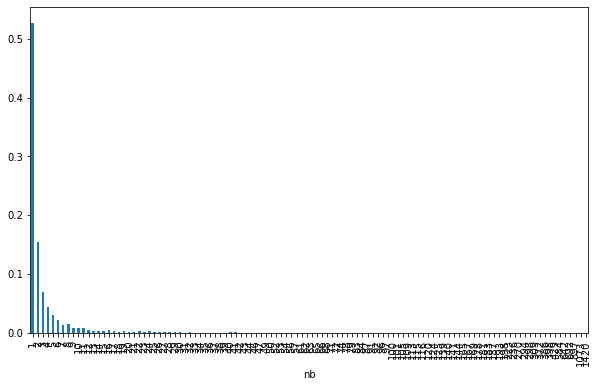

In [19]:
show_distribution_col(simple_tags_df, 'nb', 1)

nb_tags :
 [1 2 3 4 5] 



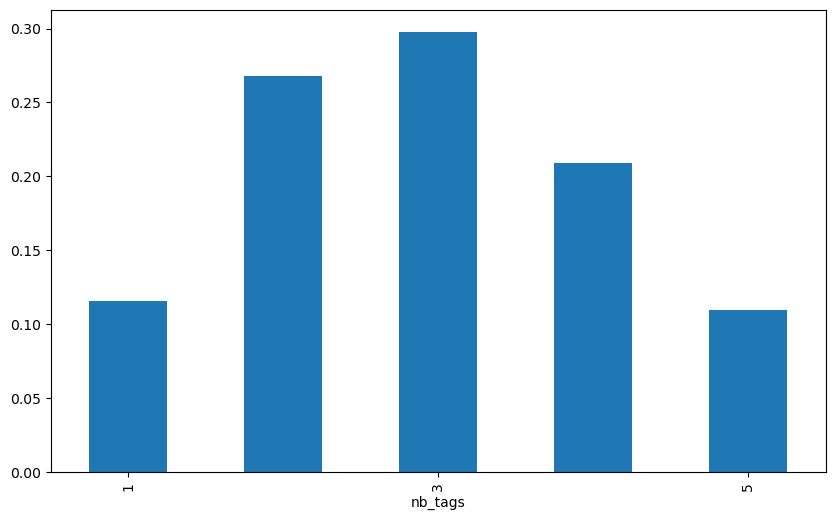

In [20]:
df['nb_tags'] = df['simple_tags'].apply(lambda tags: len(tags))
show_distribution_col(df, 'nb_tags', 2)

In [21]:
print("Les", nb_100, "premiers :\n",
      simple_tags_df[simple_tags_df['nb'] > 100])

Les 45 premiers :
                      nb
0                      
c#                 1420
.net               1073
java                897
c++                 692
python              642
javascript          584
asp.net             429
sql-server          398
sql                 386
php                 372
c                   309
visual-studio       298
html                294
windows             270
ruby                236
database            223
jquery              198
css                 193
language-agnostic   193
mysql               187
algorithm           183
performance         181
linux               181
string              178
svn                 169
unit-testing        167
xml                 165
regex               144
version-control     141
wpf                 140
oop                 139
iphone              125
winforms            124
multithreading      120
objective-c         116
perl                115
linq                115
exception           113
debugging           1

Je récupère la liste des ces tags les plus populaires.

In [22]:
top_tags = [t[0] for t in simple_tags_df[simple_tags_df['nb'] > 100].index.tolist()]
print(top_tags)

['c#', '.net', 'java', 'c++', 'python', 'javascript', 'asp.net', 'sql-server', 'sql', 'php', 'c', 'visual-studio', 'html', 'windows', 'ruby', 'database', 'jquery', 'css', 'language-agnostic', 'mysql', 'algorithm', 'performance', 'linux', 'string', 'svn', 'unit-testing', 'xml', 'regex', 'version-control', 'wpf', 'oop', 'iphone', 'winforms', 'multithreading', 'objective-c', 'perl', 'linq', 'exception', 'debugging', 'security', 'eclipse']


Je récupère également leur fréquence associée, afin de pouvoir les représenter graphiquement.

In [23]:
def get_tags_freq(data):
    """
    Renvoie un objet dict représentant la fréquence
    pour chaque élément de l'index.
    
    Args:
        data: la Series d'un dataframe à utiliser
    """
    tags_freq = {}
    for i, t in enumerate(data.index.tolist()):
        tags_freq[t[0]] = simple_tags_df['nb'][i]
    return tags_freq


def show_wc(wordcloud):
    """
    Affiche une image représenant un "wordcloud" utilisant
    l'objet passé en paramètre, généré de différentes façons.
    
    Args:
        wordcloud: l'objet wordcloud à afficher
    """
    plt.figure(figsize=[12,7])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

def show_wordcloud(data):
    """
    Affiche une image représentant les mots dans un "wordcloud"
    basé sur leur fréquence.
    
    Args:
        data: la Series d'un dataframe à utiliser
    """
    tags_freq = get_tags_freq(data)
    wordcloud = WordCloud().generate_from_frequencies(tags_freq)
    show_wc(wordcloud)
    
def show_wordcloud_from_text(text):
    """
    Affiche une image représentant les mots dans un "wordcloud"
    basé sur leur fréquence dans le texte passé en paramètre.
    
    Args:
        text: le texte à utiliser
    """
    wordcloud = WordCloud().generate(text)
    show_wc(wordcloud)
    

A l'aide du module WordCloud, je génère une représentation des tags en fonction de leur représentation dans le jeu de données. Un premier "nuage" avec tous les tags, et un second avec uniquement les tags présents plus de 100 fois.

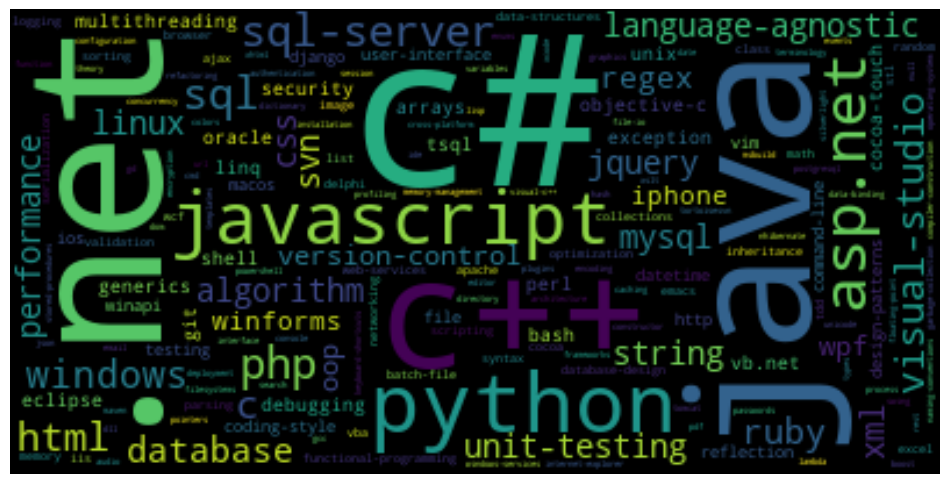

In [24]:
show_wordcloud(simple_tags_df)

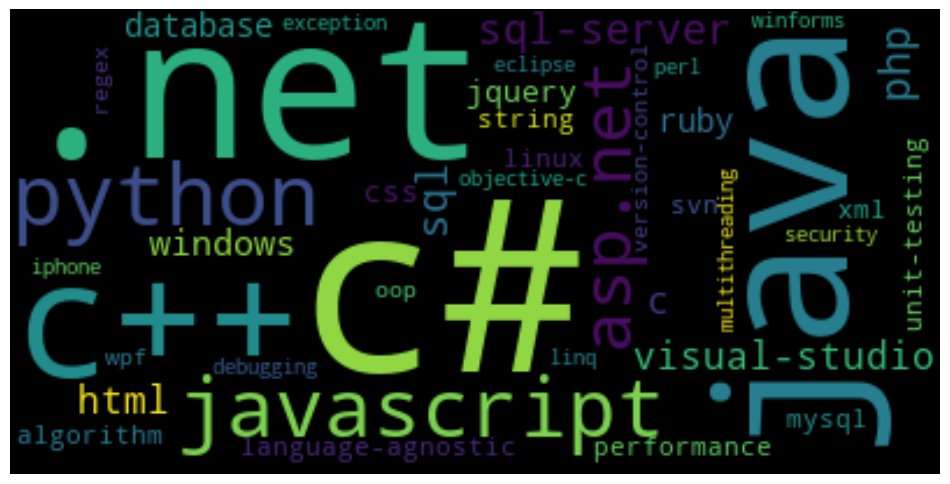

In [25]:
show_wordcloud(simple_tags_df[simple_tags_df['nb'] > 100])

Je décide de ne conserver que les tags les plus utilisés. J'expérimente mon filtre sur les 10 premières lignes.

In [26]:
df[:10]['simple_tags']

0    [c#, decimal, double, type-conversion, floatin...
1                       [css, internet-explorer, html]
2                                 [c#, .net, datetime]
3    [c#, time, datediff, datetime, relative-time-s...
4         [mysql, binary-data, data-storage, database]
5    [unix, language-agnostic, performance, pi, alg...
6                          [mysql, triggers, database]
7                    [sockets, zos, c++, mainframe, c]
8                  [rdbms, sql-server, sql, datatable]
9                            [c#, timer, .net, vb.net]
Name: simple_tags, dtype: object

In [27]:
[[t for t in tags_col if t in top_tags] for tags_col in df[:10]['simple_tags']]

[['c#'],
 ['css', 'html'],
 ['c#', '.net'],
 ['c#'],
 ['mysql', 'database'],
 ['language-agnostic', 'performance', 'algorithm'],
 ['mysql', 'database'],
 ['c++', 'c'],
 ['sql-server', 'sql'],
 ['c#', '.net']]

Puis j'applique le filtre sur toutes les données.

In [28]:
df['tags_filtered'] = [[t for t in tags_col if t in top_tags] for tags_col in df['simple_tags']]

Maintenant je dois avoir des lignes pour lesquelles la colonne est vide :

In [29]:
df['tags_filtered']

0                                 [c#]
1                          [css, html]
2                           [c#, .net]
3                                 [c#]
4                    [mysql, database]
                      ...             
188060                    [javascript]
188061    [c#, visual-studio, asp.net]
188062                              []
188063                        [python]
188064                              []
Name: tags_filtered, Length: 188065, dtype: object

Je supprime donc les lignes où il n'y a plus de tag

In [30]:
nb_avant = df.shape[0]
print("Nombre de lignes avant :", nb_avant)
df = df.loc[df["tags_filtered"].apply(len) > 0]
nb_apres = df.shape[0]
print("Nombre de lignes après :", nb_apres)
print("Soit une diminution de :", 100 - round(nb_apres * 100 / nb_avant), "%")

Nombre de lignes avant : 188065
Nombre de lignes après : 139042
Soit une diminution de : 26 %


Je regarde maintenant la distribution des longueurs de textes, pour le "Title" et le "Body"

title_len :
 [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150] 



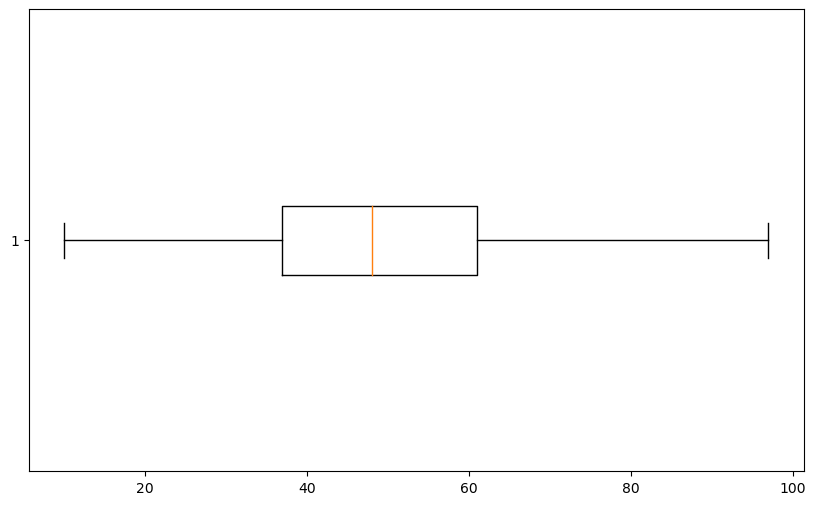

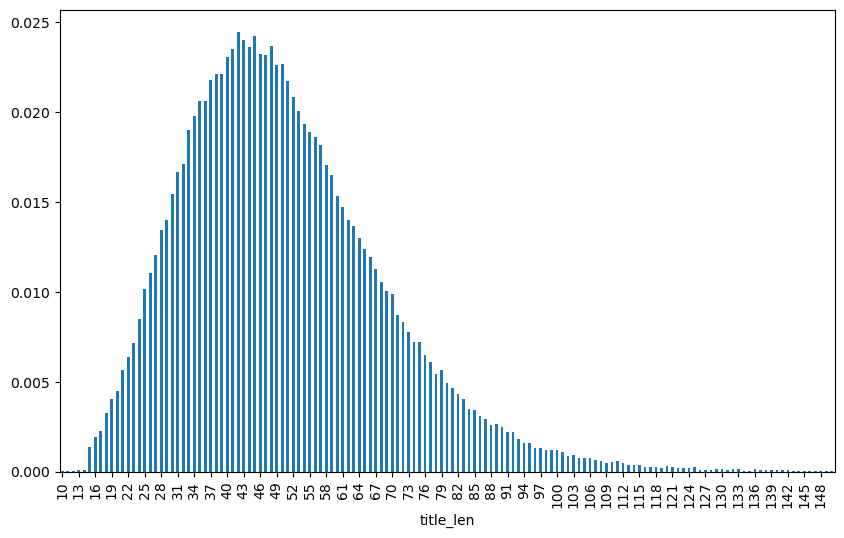

body_len :
 [   25    28    29 ... 29516 30495 37279] 



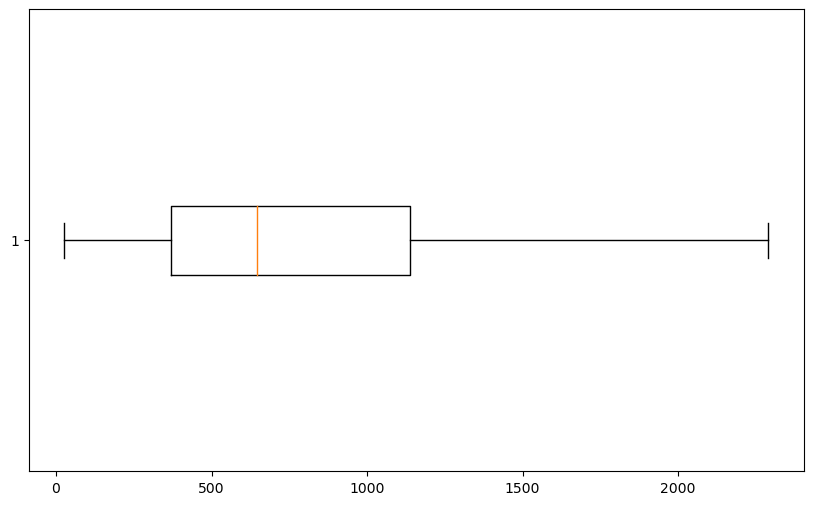

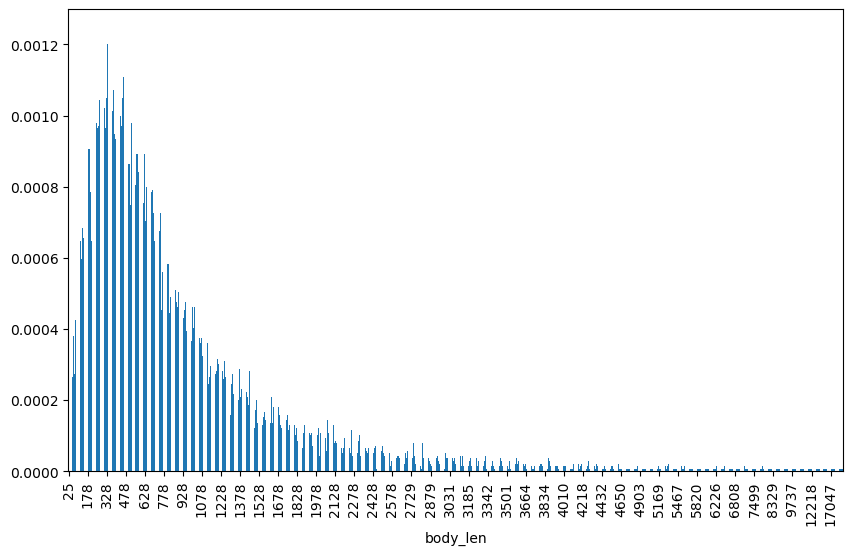

In [31]:
df['title_len'] = df['Title'].apply(lambda title: len(title))
df['body_len'] = df['Body'].apply(lambda body: len(body))
show_distribution_col(df, 'title_len', 3)
show_distribution_col(df, 'body_len', 150)

In [32]:
df['Body']

0         <p>I want to use a <code>Track-Bar</code> to c...
1         <p>I have an absolutely positioned <code>div</...
2         <p>Given a <code>DateTime</code> representing ...
3         <p>Given a specific <code>DateTime</code> valu...
4         <p>How do I store binary data in <a href="http...
                                ...                        
188058    <p>I'm embarrassed to ask this and it's most l...
188059    <p>I think this is a very basic question but I...
188060    <p>Is there a way to have code coverage in the...
188061    <p>I am unable to edit any files in a project ...
188063    <p>This may take a second to explain so please...
Name: Body, Length: 139042, dtype: object

Il y a des balises HTML dans le "Body" des questions. J'utilise Beautiful Soup pour les supprimer.

In [33]:
def cleanhtml(raw_html):
    if len(raw_html) > 0:
        soup = BeautifulSoup(raw_html, 'html.parser')
        return soup.get_text().replace("\n", " ")
    else:
        return raw_html

In [34]:
# Test de la méthode sur la première ligne du tableau
cleanhtml(df['Body'][0])

"I want to use a Track-Bar to change a Form's opacity. This is my code: decimal trans = trackBar1.Value / 5000; this.Opacity = trans;  When I build the application, it gives the following error:  Cannot implicitly convert type decimal to double   I have tried using trans and double, but then the Control doesn't work. This code worked fine in a past VB.NET project. "

In [35]:
df['body_clean'] = df['Body'].apply(lambda body: cleanhtml(body))

Je concatène maintenant les colonnes "Title" et "Body" pour n'avoir qu'une seule source de texte.

In [36]:
df['txt'] = df['Title'] + ' ' + df['body_clean']

In [37]:
df[['Title', 'Body', 'txt']]

,Title,Body,txt
0,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,How to convert a Decimal to a Double in C#? I ...
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,Why did the width collapse in the percentage w...
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age based on a Da...
3,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C# Given a specific...
4,Binary Data in MySQL,"<p>How do I store binary data in <a href=""http...",Binary Data in MySQL How do I store binary dat...
...,...,...,...
188058,How to access N-th element of an array in PHP,<p>I'm embarrassed to ask this and it's most l...,How to access N-th element of an array in PHP ...
188059,"C++: ""vector<int>::size_type variable"" - what ...",<p>I think this is a very basic question but I...,"C++: ""vector<int>::size_type variable"" - what ..."
188060,How to get the code coverage report using Jest?,<p>Is there a way to have code coverage in the...,How to get the code coverage report using Jest...
188061,Unable to type in Visual Studio,<p>I am unable to edit any files in a project ...,Unable to type in Visual Studio I am unable to...


Je concatène tous les textes dans une seule chaine pour pouvoir générer un wordcloud. Pour éviter des problèmes de mémoire, je ne prends en compte que les 20.000 premières lignes.

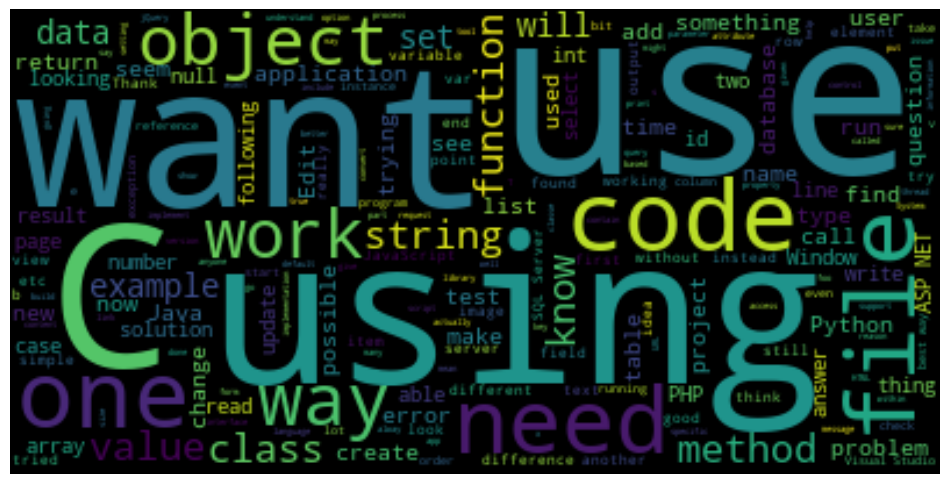

In [38]:
all_txt = ' '.join(df['txt'][:20000].tolist())
show_wordcloud_from_text(all_txt)

In [39]:
# Suppression de la ponctuation
# Séparation en token en minuscules
tokenizer = nltk.RegexpTokenizer(r'\w+')
df['txt'] = [tokenizer.tokenize(txt.lower()) for txt in df['txt']]
df['txt']

0         [how, to, convert, a, decimal, to, a, double, ...
1         [why, did, the, width, collapse, in, the, perc...
2         [how, do, i, calculate, someone, s, age, based...
3         [calculate, relative, time, in, c, given, a, s...
4         [binary, data, in, mysql, how, do, i, store, b...
                                ...                        
188058    [how, to, access, n, th, element, of, an, arra...
188059    [c, vector, int, size_type, variable, what, is...
188060    [how, to, get, the, code, coverage, report, us...
188061    [unable, to, type, in, visual, studio, i, am, ...
188063    [how, to, get, google, analytics, credentials,...
Name: txt, Length: 139042, dtype: object

In [40]:
# On récupère une liste de stopwords anglais
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Julien
[nltk_data]     Gremillot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Suppression des stopwords
df['txt'] = [[w for w in tokens if not w in sw] for tokens in df['txt']]

In [42]:
df['txt'][0]

['convert',
 'decimal',
 'double',
 'c',
 'want',
 'use',
 'track',
 'bar',
 'change',
 'form',
 'opacity',
 'code',
 'decimal',
 'trans',
 'trackbar1',
 'value',
 '5000',
 'opacity',
 'trans',
 'build',
 'application',
 'gives',
 'following',
 'error',
 'cannot',
 'implicitly',
 'convert',
 'type',
 'decimal',
 'double',
 'tried',
 'using',
 'trans',
 'double',
 'control',
 'work',
 'code',
 'worked',
 'fine',
 'past',
 'vb',
 'net',
 'project']

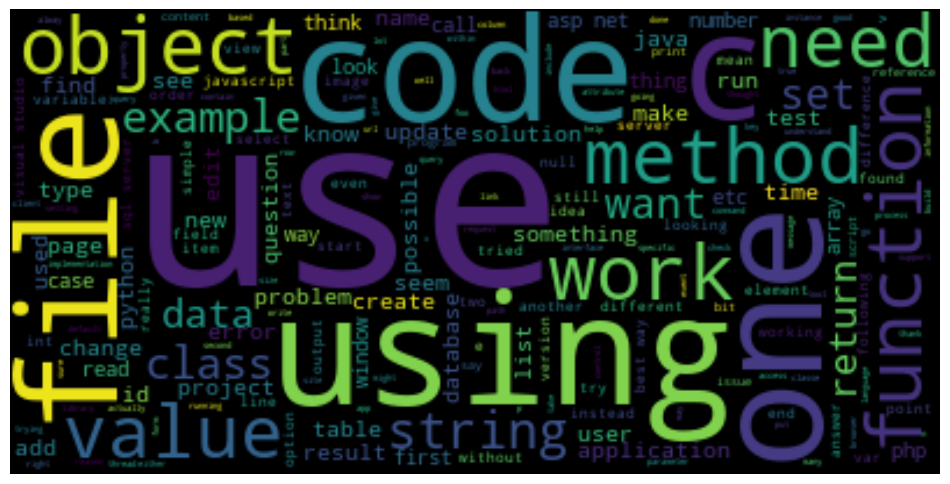

In [50]:
def get_text(arr):
    return ' '.join(arr)
all_txt_after = ' '.join(df['txt'][:20000].apply(get_text).tolist())
show_wordcloud_from_text(all_txt_after)

In [52]:
csv_to_save = df[['txt', 'tags_filtered']]
csv_to_save.to_csv("txt_and_tags.csv", index=False)

In [ ]:
n_topics = 20
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(df['txt_base'])

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

In [ ]:
# Test vectorisation TF-IDF sur le premier texte
vectorizer = TfidfVectorizer(analyzer='word')
X = vectorizer.fit_transform(df['txt'][0])
print("len(vectorizer.get_feature_names()) =",
      len(vectorizer.get_feature_names()))
print("X.shape =", X.shape)

In [ ]:
tfidf_tokens = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data=X.toarray(), columns=tfidf_tokens)

In [ ]:
tfidf_tokens

In [ ]:
print(" convert:", df_tfidfvect['convert'].sum(), "\n",
      "decimal:", df_tfidfvect['decimal'].sum(), "\n",
      "double:", df_tfidfvect['double'].sum())

In [ ]:
df['txt_base'] = df['Title'] + ' ' + df['body_clean']